In [327]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Data Exploration

Data sample:


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."



Data shape: (39774, 3)

Missing values by column:
id             0
cuisine        0
ingredients    0
dtype: int64

Number of classes: 20


<Axes: title={'center': 'Class Balance'}, xlabel='Class', ylabel='Number'>

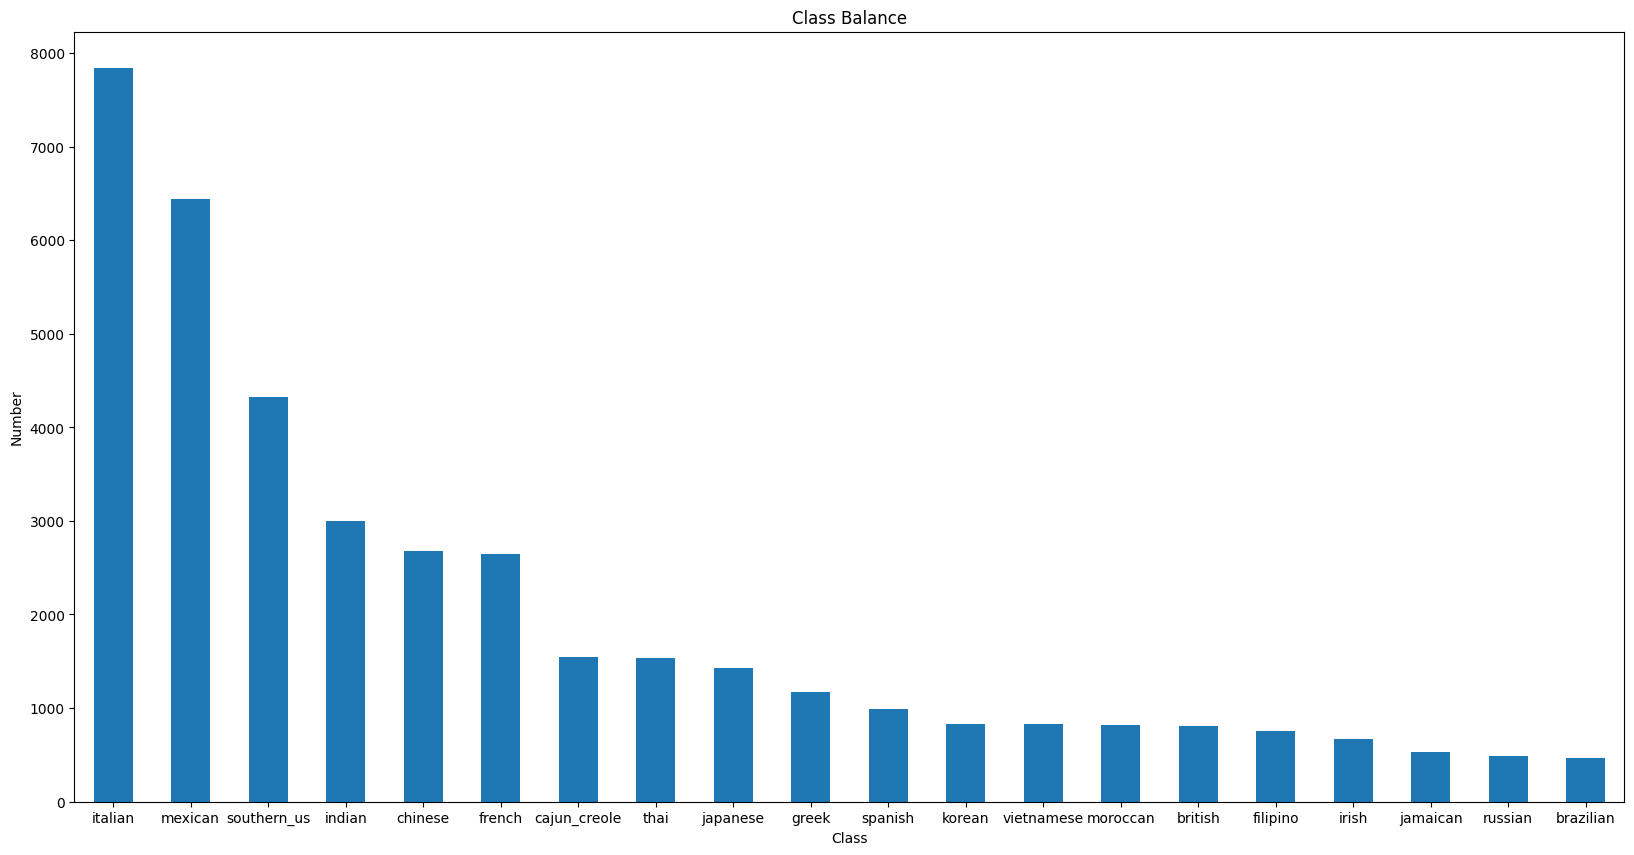

In [300]:
# Read data from the datasource (external json file)
data = pd.read_json('./data/train.json')

# Check the data general params and integrity
print('Data sample:')
display(data.head())
print('\nData shape:', data.shape)
print('\nMissing values by column:')
print(data.isnull().sum())
print('\nNumber of classes:', data['cuisine'].nunique())

# Check the class balance visually with bar plot
data['cuisine'].value_counts().plot(
            kind='bar', 
            rot=0, 
            figsize=(20, 10), 
            title='Class Balance', 
            ylabel='Number', 
            xlabel='Class'
)

# Data Transformation

In [313]:
# Put all features to the table matching with future input vector index
ingredients = set()
for elm_ingredients in data['ingredients']:
    ingredients.update(elm_ingredients)

ingredients = np.array(list(ingredients))
features = pd.DataFrame(index=ingredients, data={'feature': ingredients, 'vector_position': range(len(ingredients))})
print('Features to vector index table:')
display(features.head())

# Put all classes labels to the table matching with future output number
cuisine = data['cuisine'].unique()
labels = pd.DataFrame(index=cuisine, data={'label': cuisine, 'number': range(len(cuisine))})

print('Labels to class number representation table:')
display(labels.head())


# Transform data
# Transform features to n-dimensional vector (n - unique features total).
# Each feature is mapped on {0, 1}:
#       '1' - represents 'True'/ingredient included
#       '0' - 'False'/ingredient is absent.
# Transform expected output to numbers, representing class labels 
#       mapped on {0, 1, .., m} (m - total number of classes).
# Aggregate all input vectors to matrix.
# Aggregate all output values to vector.
x = []
y = np.array([], dtype=int)

for i, row in data.iterrows():
    predictors_vector = np.zeros(len(ingredients), dtype=int)
    for ingredient in row['ingredients']:
        vector_position = features.loc[ingredient]['vector_position']
        predictors_vector[vector_position] = 1
    x.append(predictors_vector)
    cuisine = row['cuisine']
    class_number = labels.loc[cuisine]['number']
    y = np.append(y, class_number)

x = np.array(x)

print('\nPredictors matrix m x n:', x.shape)
print(x[:5])
print('\nTarget vector of length:', y.shape)
print(y[:20])

Features to vector index table:


,feature,vector_position
pangasius,pangasius,0
dried sardines,dried sardines,1
shredded romano cheese,shredded romano cheese,2
dried pear,dried pear,3
bitter gourd,bitter gourd,4


Labels to class number representation table:


,label,number
greek,greek,0
southern_us,southern_us,1
filipino,filipino,2
indian,indian,3
jamaican,jamaican,4



Predictors matrix m x n: (39774, 6714)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Target vector of length: (39774,)
[ 0  1  2  3  3  4  5  6  7  6  6  8  6  7  6  3  9  6 10 11]


In [314]:
# Split data on test/train sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print('Number of train entires: ', len(x_train))
print('Number of test entries:', len(x_test))

Number of train entires:  31819
Number of test entries: 7955


# Model Selection and Training

In [315]:
# Select 3 models as possible classifiers
cl_lr = LogisticRegression()
cl_rf = RandomForestClassifier()
cl_svc = LinearSVC()

# Set up basic pipeline
pipeline = Pipeline([('classifier', cl_lr)])

# Create grid with pipeline and params for different classifiers
grid = GridSearchCV(
    estimator=pipeline, 
    param_grid=[
        {
            'classifier': [cl_lr], 
            'classifier__max_iter':[100, 1000, 3000], 
            'classifier__class_weight':['balanced', None]
        },
        {
            'classifier': [cl_rf], 
            'classifier__n_estimators':[50, 100, 150], 
            'classifier__class_weight':['balanced', None]
        },
        {
            'classifier': [cl_svc], 
            'classifier__penalty':['l1', 'l2'], 
            'classifier__class_weight':['balanced', None]
        }
    ]
)

# Start training with grid on selected classifiers 
#       and each possible combination of the params
grid.fit(x_train, y_train)

C:\Users\herman-rog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\herman-rog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__class_weight': ['balanced', None],
                          'classifier__max_iter': [100, 1000, 3000]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__class_weight': ['balanced', None],
                          'classifier__n_estimators': [50, 100, 150]},
                         {'classifier': [LinearSVC()],
                          'classifier__class_weight': ['balanced', None],
                          'classifier__penalty': ['l1', 'l2']}])

# Analyze the Results

In [330]:
# Explore the grid result
print('Best selected model and params:', grid.best_params_)

# Predict with best selected model and params
y_predict = grid.predict(x_test)

# Best model accuracy
print('Accuracy:', accuracy_score(y_pred=y_predict, y_true=y_test))

labels_list = labels['label'].values
# Best model accuracy
print('\nClassification Report:\n', classification_report(y_test, y_predict, target_names=labels_list))
print('\nConfusion Matrix:')
cm = pd.DataFrame(confusion_matrix(y_test, y_predict))
cm.index, cm.columns = labels_list, labels_list
display(cm)

Best selected model and params: {'classifier': LogisticRegression(), 'classifier__class_weight': None, 'classifier__max_iter': 100}
Accuracy: 0.7791326209930861

Classification Report:
               precision    recall  f1-score   support

       greek       0.81      0.67      0.73       250
 southern_us       0.71      0.79      0.75       902
    filipino       0.66      0.61      0.64       155
      indian       0.84      0.88      0.86       587
    jamaican       0.81      0.65      0.72       103
     spanish       0.66      0.51      0.58       193
     italian       0.79      0.90      0.84      1592
     mexican       0.90      0.91      0.91      1280
     chinese       0.83      0.82      0.82       521
     british       0.58      0.43      0.49       149
        thai       0.79      0.70      0.75       335
  vietnamese       0.60      0.61      0.61       152
cajun_creole       0.79      0.70      0.74       307
   brazilian       0.70      0.55      0.62        80
   

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
greek,167,4,1,2,0,3,51,3,0,1,1,0,0,0,10,1,0,0,5,1
southern_us,1,715,2,3,4,8,47,21,6,8,0,0,39,3,30,2,9,0,0,4
filipino,0,13,95,3,1,0,8,5,12,0,6,4,1,1,2,2,1,1,0,0
indian,2,13,2,515,1,2,8,9,1,2,8,1,0,1,4,10,0,0,6,2
jamaican,0,13,2,4,67,2,2,7,1,0,0,1,1,0,0,1,1,0,0,1
spanish,3,4,1,1,0,99,45,19,0,0,2,0,1,2,12,0,1,0,0,3
italian,18,29,1,7,1,6,1431,15,0,5,1,1,1,0,71,3,1,0,0,1
mexican,2,39,3,9,0,11,19,1169,1,1,1,0,4,4,11,2,0,0,4,0
chinese,0,11,6,6,1,0,12,8,428,1,10,9,0,2,1,18,0,8,0,0
british,1,22,0,4,1,0,13,0,1,64,0,0,1,0,24,0,15,0,0,3


<Axes: title={'center': 'Models Accuracy (on training dataset size)'}>

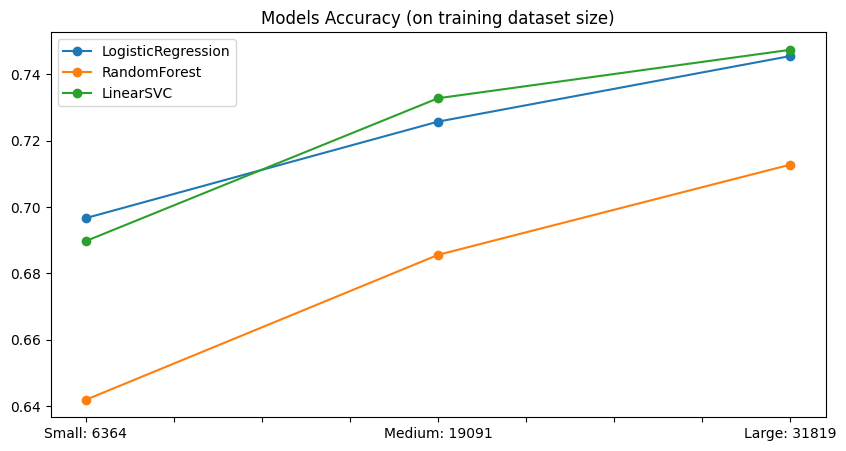

In [21]:
result = pd.DataFrame(
    {
        'LogisticRegression': [lr_s_r2, lr_s_r1, lr_s], 
        'RandomForest': [rf_s_r2, rf_s_r1, rf_s],
        'LinearSVC': [svc_s_r2, svc_s_r1, svc_s]
    }
)
result.rename(
    index={
        0: 'Small: ' + str(len(x_train_reduced_2)), 
        1: 'Medium: ' + str(len(x_train_reduced_1)), 
        2: 'Large: ' + str(len(x_train))
    }, 
    inplace=True
)
result.plot(kind='line', rot=0, figsize=(10, 5), style='o-', title='Models Accuracy (on training dataset size)')

